Exploring Ensemble Methods
In this homework we will explore the use of boosting. For this assignment, we will use the pre-implemented gradient boosted trees in Graphlab-Create. You will:

Use SFrames to do some feature engineering.
Train a boosted ensemble of decision-trees (gradient boosted trees) on the lending club dataset.
Predict whether a loan will default along with prediction probabilities (on a validation set).
Evaluate the trained model and compare it with a baseline.
Find the most positive and negative loans using the learned model.
Explore how the number of trees influences classification performance

In [1]:
import pandas as pd
import numpy as np


# prepare data

In [3]:
loans=pd.read_csv('lending-club-data.csv')

#modify target column

loans['safe_loans']=loans['bad_loans'].apply(lambda x: 1 if x==0 else -1)
loans.drop('bad_loans', axis=1, inplace=True)

In [4]:
loans.shape

(122607, 68)

In [5]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]


In [6]:
loans_with_NA=loans[[target]+ features]

In [7]:
#make subset with no NA rows
loans=loans[[target]+ features].dropna()

In [8]:
#check num rows
loans_with_NA.shape, loans.shape

((122607, 25), (122578, 25))

In [14]:
# do one hot encoding
loans=pd.get_dummies(loans)

In [15]:
train_idx=pd.read_json('module-8-assignment-1-train-idx.json', typ='series')
valid_idx=pd.read_json('module-8-assignment-1-validation-idx.json', typ='series')

In [16]:
train=loans.iloc[train_idx]
valid=loans.iloc[valid_idx]

X_train=train.iloc[:,1:]
y_train=train.iloc[:,0]

X_valid=valid.iloc[:,1:]
y_valid=valid.iloc[:,0]

# gradient boosted tree

In [17]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [18]:
clf_5=GBC(n_estimators=5, max_depth=6).fit(X_train,y_train)

In [19]:
# take 2 neg pos examples
sample_valid_safe=valid[valid[target] ==1][0:2]
sample_valid_risky=valid[valid[target] == -1][0:2]
sample_valid=sample_valid_safe.append(sample_valid_risky)

In [20]:
sample_valid

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [22]:
pred_sample = clf_5.predict(sample_valid.iloc[:,1:])
pred_sample

array([ 1,  1, -1,  1], dtype=int64)

In [18]:
perc_right = len(sample_valid[sample_valid['safe_loans'] == pred_sample])/float(len(sample_valid))
perc_right

0.75

In [23]:
pred_sample_2=clf_5.predict_proba(sample_valid.iloc[:,1:])

In [24]:
pred_sample_2

array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

In [21]:
print('Accuracy of this model is: {:.3}'.format(clf_5.score(X_valid,y_valid)))

Accuracy of this model is: 0.661


In [22]:
# calc false positives
from sklearn.metrics import confusion_matrix
y_predicted=clf_5.predict(X_valid)
confusion=confusion_matrix(y_valid,y_predicted)
print('number of false positive: {}'.format(confusion[1,0]))

number of false positive: 1491


In [23]:
# confusuion amtrix is confusing..
confusion

array([[3019, 1653],
       [1491, 3121]], dtype=int64)

In [24]:
conf_table=pd.crosstab(y_valid, y_predicted, rownames=['True'], colnames=['Predicted'], margins=True)
conf_table

Predicted,-1,1,All
True,,,
-1,3019,1653,4672
1,1491,3121,4612
All,4510,4774,9284


# Q4 Calculate the cost of mistakes made by model_5 on the validation_data.
- False negatives: Assume a cost of $10,000 per false negative.

- False positives: Assume a cost of $20,000 per false positive

In [25]:
cost= 10000*int(conf_table.iloc[1,0]) + 20000*int(conf_table.iloc[0,1])
cost

47970000

# most pos and neg loans

In [28]:
y_predicted_proba=clf_5.predict_proba(X_valid)

In [29]:
y_predicted_proba[:,1]

array([0.46192208, 0.60408361, 0.47987242, ..., 0.46469023, 0.47719076,
       0.46192208])

In [30]:
valid['predictions']=y_predicted_proba[:,1]

C:\Users\Keulando\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
top_predictions=valid.sort_values(by='predictions', ascending=False)
top_grades=top_predictions[['predictions','grade_A','grade_B','grade_C','grade_D','grade_E','grade_F']]

In [32]:
top_grades.head(5)

,predictions,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F
8021,0.673059,1,0,0,0,0,0
34261,0.661468,1,0,0,0,0,0
68947,0.661468,1,0,0,0,0,0
99626,0.661468,1,0,0,0,0,0
69995,0.661468,1,0,0,0,0,0


In [35]:
lowest_predictions=valid.sort_values(by='predictions', ascending=True)
lowest_grades=lowest_predictions[['predictions','grade_A','grade_B','grade_C','grade_D','grade_E','grade_F','grade_G']]

In [36]:
lowest_grades.head(5)

,predictions,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
84508,0.307334,0,0,1,0,0,0,0
58794,0.307334,0,0,1,0,0,0,0
27502,0.312806,0,0,1,0,0,0,0
114781,0.315969,0,0,0,1,0,0,0
84921,0.315969,0,0,1,0,0,0,0


# Effects of adding more trees


In [37]:
model_10=GBC(n_estimators=10, max_depth=6).fit(X_train,y_train)
model_50=GBC(n_estimators=50, max_depth=6).fit(X_train,y_train)
model_100=GBC(n_estimators=100, max_depth=6).fit(X_train,y_train)
model_200=GBC(n_estimators=200, max_depth=6).fit(X_train,y_train)
model_500=GBC(n_estimators=500, max_depth=6).fit(X_train,y_train)

In [42]:
accu_10_valid=model_10.score(X_valid,y_valid)
accu_50_valid=model_50.score(X_valid,y_valid)
accu_100_valid=model_100.score(X_valid,y_valid)
accu_200_valid=model_200.score(X_valid,y_valid)
accu_500_valid=model_500.score(X_valid,y_valid)

In [43]:
accu_10_train=model_10.score(X_train,y_train)
accu_50_train=model_50.score(X_train,y_train)
accu_100_train=model_100.score(X_train,y_train)
accu_200_train=model_200.score(X_train,y_train)
accu_500_train=model_500.score(X_train,y_train)

In [41]:
print('Accuracy of model with 10 estimators is: {:.3}\n'.format(model_10.score(X_valid,y_valid)))
print('Accuracy of model with 50 estimators is: {:.3}\n'.format(model_50.score(X_valid,y_valid)))
print('Accuracy of model with 100 estimators is: {:.3}\n'.format(model_100.score(X_valid,y_valid)))
print('Accuracy of model with 200 estimators is: {:.3}\n'.format(model_200.score(X_valid,y_valid)))
print('Accuracy of model with 500 estimators is: {:.3}\n'.format(model_500.score(X_valid,y_valid)))


Accuracy of model with 10 estimators is: 0.666

Accuracy of model with 50 estimators is: 0.682

Accuracy of model with 100 estimators is: 0.688

Accuracy of model with 200 estimators is: 0.691

Accuracy of model with 500 estimators is: 0.687



# Plot the training and validation error vs. number of trees


In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [46]:
#classific error 

errors=pd.DataFrame({'model_10':{'Train error':1-accu_10_train,
                                'Validation error':1- accu_10_valid},
                    'model_50':{'Train error':1-accu_50_train,
                                'Validation error':1- accu_50_valid},
                    'model_100':{'Train error':1-accu_100_train,
                                'Validation error':1- accu_100_valid},
                    'model_200':{'Train error':1-accu_200_train,
                                'Validation error': 1-accu_200_valid},
                    'model_500':{'Train error':1-accu_500_train,
                                'Validation error':1- accu_500_valid}})
errors

,model_10,model_100,model_200,model_50,model_500
Train error,0.328327,0.254091,0.213359,0.283242,0.134582
Validation error,0.333692,0.311827,0.309242,0.318290,0.313335


In [50]:
train_error=errors.loc['Train error'].tolist()
valid_error=errors.loc['Validation error'].tolist()


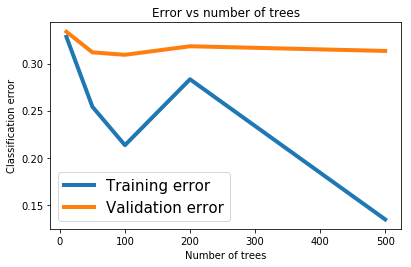

In [55]:
plt.plot([10, 50, 100, 200, 500], train_error, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], valid_error, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')